In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

# Data

Shape (36, 39)


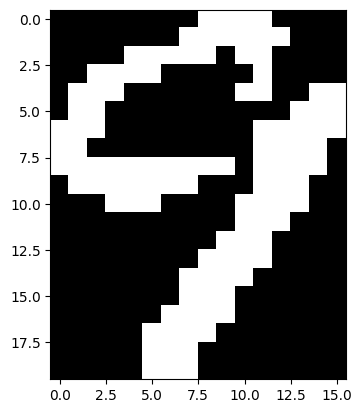

In [2]:
alpha_digit = sio.loadmat("data/binaryalphadigs.mat", squeeze_me=True)["dat"]

print("Shape", alpha_digit.shape)

plt.imshow(alpha_digit[9][0], cmap="gray")
plt.show()

In [32]:
def lire_alpha_digit(alpha_digits, chars):
    arr = []
    y = []
    for i, char in enumerate(chars):
        if type(char) == int:
            char = str(char)

        asc_char = ord(char)
        if asc_char >= 65 and asc_char <= 90:
            for digit in alpha_digits[asc_char - 55]:
                arr.append(digit.flatten())
                y.append(asc_char - 55)
        elif asc_char >= 48 and asc_char <= 57:
            for digit in alpha_digits[asc_char - 48]:
                arr.append(digit.flatten())
                y.append(asc_char - 48)
        else:
            raise Exception("Char not valid")
    return np.array(arr), np.array(y)

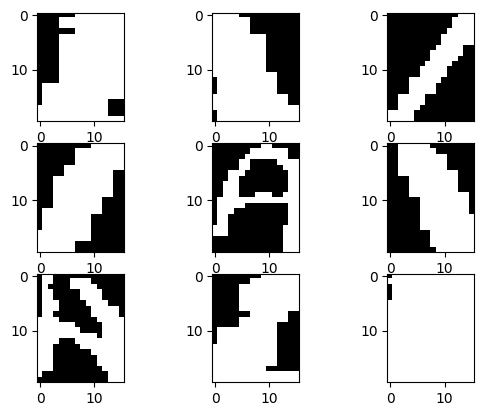

In [41]:
data_digits, labels_digits = lire_alpha_digit(alpha_digit, ["1", "A"])
fig, axs = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        idx = np.random.randint(0, data_digits.shape[0])
        axs[i, j].imshow(data_digits[idx].reshape(20, 16), cmap="gray")
plt.show()

# Fonctions élémentaires

## RBM

In [42]:
class RBM:
    def __init__(self, p, q):
        self.W = np.random.normal(loc=0, scale=np.sqrt(0.01), size=(p, q))
        self.a = np.zeros(p)
        self.b = np.zeros(q)


def init_RBM(p, q):
    return RBM(p, q)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def entree_sortie_RBM(rbm, X):
    return sigmoid(np.dot(X, rbm.W) + rbm.b)


def sortie_entree_RBM(rbm, H):
    return sigmoid(np.dot(H, rbm.W.T) + rbm.a)


def train_RBM(rbm, X, epochs, lr, batch_size):
    p, q = rbm.W.shape
    n = X.shape[0]
    for epoch in range(epochs):
        X_copy = X.copy()
        np.random.shuffle(X_copy)

        for i in range(0, n, batch_size):
            v_0 = X_copy[i : i + batch_size]
            es_v_0 = entree_sortie_RBM(rbm, v_0)
            h_0 = (np.random.uniform(size=(len(v_0), q)) < es_v_0).astype("float")
            v_1 = (
                np.random.uniform(size=(len(v_0), p)) < sortie_entree_RBM(rbm, h_0)
            ).astype("float")
            h_1 = entree_sortie_RBM(rbm, v_1)

            rbm.W += lr / batch_size * (np.dot(v_0.T, es_v_0) - np.dot(v_1.T, h_1))
            rbm.a += lr / batch_size * np.sum(v_0 - v_1, axis=0)
            rbm.b += lr / batch_size * np.sum(es_v_0 - h_1, axis=0)


def generer_image_RBM(rbm, gibbs_iter, n_image):
    p, q = rbm.W.shape
    X = np.zeros((n_image, p))
    for i in range(n_image):
        x = (np.random.uniform(size=p) < 0.5).astype("float")

        for iter in range(gibbs_iter):
            h = (np.random.uniform(size=q) < entree_sortie_RBM(rbm, x)).astype("float")
            x = (np.random.uniform(size=p) < sortie_entree_RBM(rbm, h)).astype("float")

        X[i] = x
    return X

## DBN

In [43]:
class DBN:
    def __init__(self, feat_in, layers):
        self.rbm = self.init_RBMs(feat_in, layers)

    def init_RBMs(self, feat_in, layers):
        rbms = []
        p = feat_in
        for l in layers:
            rbm = init_RBM(p, l)
            rbms.append(rbm)
            p = l
        return rbms


def init_DBN(layers):
    return DBN(320, layers)


def train_DBN(dbn, X_init, epochs, lr, batch_size):
    for epoch in range(epochs):
        X = X_init
        for rbm in dbn.rbm:
            # print("shape", X.shape, rbm.W.shape, rbm.b.shape)
            train_RBM(rbm, X, epochs, lr, batch_size)
            X = entree_sortie_RBM(rbm, X)
    return dbn


def generer_image_DBN(dbn, gibbs_iter, n_image):
    X = generer_image_RBM(dbn.rbm[-1], gibbs_iter, n_image)
    for i in range(len(dbn.rbm) - 2, -1, -1):
        X = sortie_entree_RBM(dbn.rbm[i], X)
    return X

## DNN

In [50]:
class DNN:
    def __init__(self, layers):
        self.dbn = init_DBN(layers[:-1])


def init_DNN(layers):
    return DNN(layers)


def pretrain_DNN(dnn, X, epochs, lr, batch_size):
    train_DBN(dnn.dbn[:-1], X, epochs, lr, batch_size)


def calcul_softmax(rbm, X):
    z = np.dot(X, rbm.W) + rbm.b
    return np.exp(z) / np.sum(np.exp(z))


def entree_sortie_reseau(dnn, X):
    input = X
    activations = [input]

    for rbm in dnn.dbn[:-1]:
        output = entree_sortie_RBM(rbm, input)
        activations.append(output)
        input = output

    activations.append(calcul_softmax(dnn.dbn[-1], input))
    return activations


def retropropagation(dnn, X, y, epochs, lr, batch_size):
    for epoch in range(epochs):
        hat_y = np.ones_like(y)
        cross_entropy = np.sum(y * np.log(hat_y))
        print("CE", cross_entropy)


def test_DNN(dnn, X, y):
    pass

In [49]:
dnn = init_DNN([320, 100, 80, 2])

retropropagation(dnn, data_digits, labels_digits, 10, 0.1, 10)

CE 297.36014046021666
CE 297.36014046021666
CE 297.36014046021666
CE 297.36014046021666
CE 297.36014046021666
CE 297.36014046021666
CE 297.36014046021666
CE 297.36014046021666
CE 297.36014046021666
CE 297.36014046021666


# 4. Etude sur Binary AlphaDigit

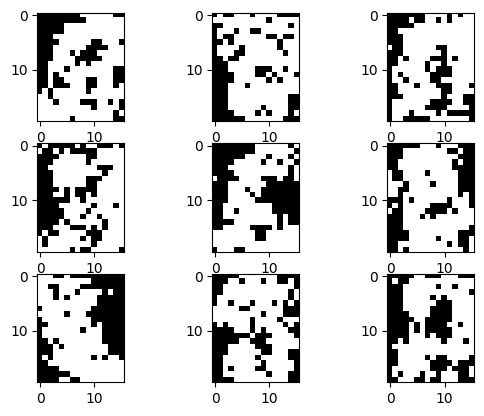

In [56]:
layers = [100, 80]
epochs = 100
lr = 0.1
batch_size = 10
gibbs_iter = 100
n_image = 9

n_rows = 20
n_cols = 16
input_size = n_rows * n_cols

chars = ["0", "A"]
small = ["0", "1", "2"]
medium = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
extra_large = [
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "J",
    "K",
    "L",
    "M",
    "N",
    "O",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
]

data, _ = lire_alpha_digit(alpha_digit, medium)

rbm = init_RBM(input_size, q=100)

train_RBM(rbm, data, epochs, lr, batch_size)

X_gen = generer_image_RBM(rbm, gibbs_iter, n_image)

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_gen.reshape(-1, n_rows, n_cols)[i], cmap="gray")
plt.show()

In [51]:
dbn = init_DBN([100, 80])
train_DBN(dbn, data, epochs, lr, batch_size)

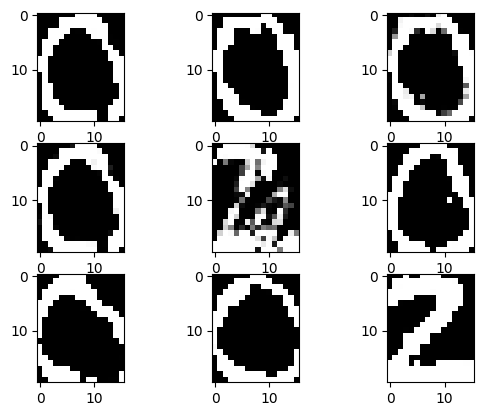

In [52]:
X_gen = generer_image_DBN(dbn, gibbs_iter, n_image)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_gen.reshape(-1, n_rows, n_cols)[i], cmap="gray")
plt.show()